Importing modules for our project so we will have everything ready beforehand.

In [1]:
%matplotlib notebook
import pandas as pd # pandas module.
import datetime # time module.
import numpy as np # numpy for math & calculations.
import pandas_datareader.data as web # read data from the net.
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import style # matplotlib graph style.
from matplotlib.finance import candlestick_ohlc # enable candlestick drawing.
from sklearn import model_selection # for machine learning.
from sklearn import preprocessing # for machine learning
from sklearn.linear_model import LinearRegression, ElasticNetCV, Ridge # for machine learning.
from sklearn.neural_network import MLPRegressor 
from sklearn.model_selection import TimeSeriesSplit # for splitting data into train and test.
style.use('fivethirtyeight') # type of style for chart.

/home/brian/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


This will retrieve and read data from yahoo finance with help of pandas datareader.

In [2]:
def read():
    start = datetime.datetime(2012, 1, 1) # start date of the data that we are going to analyse.
    end = datetime.datetime(2017, 1, 1) # the end point.
    data = web.DataReader('MU', 'yahoo', start, end) # define symbol, source, start, and end.
    return data # return data.

Method for creating a stock %k for every row in data frame. This is prerequire for stock %d.

In [3]:
def stochk(df, n): # data and time frame.
    formula = (((df.Close - df.Low.rolling(n).min())) / (df.High.rolling(n).max() - df.Low.rolling(n).min())) * 100
    stochk = pd.Series(formula, name = '%K') # create a column with name %k.
    df = df.join(stochk) # join the stochk data with df.
    return df

This calculates the moving average based on the closing price and return back to data in a column.

In [4]:
def ma(df, n):
    formula = df['Close'].rolling(n).mean() # the formula duh.
    ma = pd.Series(formula, name = 'MA'+str(n)) # give the new data a name.
    df = df.join(ma) # join the data.
    return df

Calculates the stoch %d based on stock %k. %K is required to be able to calculate this.

In [5]:
def stochd(df): # insert data frame.
    formula = df['%K'].rolling(3).mean() #in this case, K% column must exist which calculates our new values.
    stochd = pd.Series(formula, name = '%D') # name the column.
    df = df.join(stochd) # join the data.
    return df

This is called a stochastic oscillator which is used for analysing if something is overbought or oversold.
When the lines goes above 80 then it means overbought, if it's below then it means oversold.

In [6]:
def stochosc(df): # insert the data containing.
    df = stochk(df, 14) # return a column with stoch k.
    df = stochd(df) # return a column with stoch d.
    df = df[['%K', '%D']] # remove all columns in data except for K and D
    return df

This one uses the same method as the one above but does only joins the data.

In [7]:
def oscreg(df): # insert the data containing.
    df = stochk(df, 14) # return a column with stoch k.
    df = stochd(df) # return a column with stoch d.
    return df

Set the correct date format for the candlesticks. Format the column date to be able to plot candlesticks later.
Candlesticks displays the price.

In [8]:
def candlesticks(df):
    df = df.reset_index() # zero the index.
    df['Date'] = df['Date'].map(mdates.date2num) # format the date.
    return df

On-Volume balance shows us the volume level if it was negative or positive from previous day.
It's accumulation of volume in other words.

In [9]:
def obv(df): # data insert.
    df['PC'] = df['Close'].shift() # Previous close formula. Creates a new column.
    df['P/N'] = np.where(df['Close'] > df['PC'] , df['Volume'] , -df['Volume']) # Check wether it was positive volume or negative and assign value based on that.
    df['OBV'] = np.cumsum(np.array(df['P/N'])) # On-balance Volume formula.
    df = df[['OBV']] # OVB is often displayed in a chart by itself.
    
    fig, ax = plt.subplots() # setup the fig and ax.
    ax.xaxis_date()  # set up the date axis.
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.set_ylabel("Volume") # set y label.
    ax.set_title("On-Balance Volume") # set title label. 
    ax.set_xlabel("Date") # set x label.
    plt.plot(df, linewidth = 0.5)

This method is the method that trains our module and predict. Our forecast system.

In [10]:
def train_predict(df):
    df['Label'] = df['Close'].shift(-1) # assign values to label which is one step ahead of %D.
    df = df.dropna() # drops all nan values that are found in data frame.
    
    X = np.array(df.drop(['Label'], 1)) # in X, drop the label column. input value.
    y = np.array(df['Label']) # in y, keep it. It's the expected outcome.
    y = y.reshape(-1, 1 )
    
    scaler = preprocessing.StandardScaler().fit(y) # scale function.
    X = scaler.transform(X)
    y = scaler.transform(y)
    
    tscv = TimeSeriesSplit(n_splits=5) # split the test into 80 / 20.
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index] # assign values to X_train, X_test
        y_train, y_test = y[train_index], y[test_index] # assign values to y_train, y_test
    linear = LinearRegression() # choose our regression.
    linear.fit(X_train, y_train.reshape(len(y_train),)) #fit or train the module, so it works!
    forecast_set = linear.predict(X_test) # predict based on X_test
    
    
    investment(X_test[:,0], y_test[:,0], forecast_set, df)
    return X_test[:,0], y_test[:,0], forecast_set 
    

Make investment decisions based on the regression output. The output data will show when exactly and what date to buy.

In [11]:
def investment(x_value, y_value, f_cast, df):
    df = df.reset_index() # reset the index else we will get NaN values.
    
    xtest = pd.Series(x_value, name = 'X_TEST') # name the column for X. Value at the moment
    ytest = pd.Series(y_value, name = 'y_TEST') # name the column for X. Expected value.
    forecast = pd.Series(f_cast, name = 'Forecast') # name the column for X. Forecast.

    df = df.join(xtest) # join the data.

    df = df.join(ytest) # join the data.

    df = df.join(forecast) # join the data.
    
    
    #if the y_Test is higher than forecast value then return plus positive, else return negative value (difference between the two values)
    df['Y&F'] = np.where((df['y_TEST'] > df['Forecast']),(df['y_TEST'] - df['Forecast']) , (df['y_TEST'] + df['Forecast']) )
    df['Decision'] = np.where(np.logical_and(df['X_TEST'] > df['y_TEST'],df['Y&F'] < 0), "Sell" , "Buy")
    
    df = df[['Y&F', 'Date', 'Decision']]
    df.set_index('Date', inplace=True)
    
    print(df.head())

The method for plotting the linear regression line.

In [12]:
def linear_regression(data):
    data = oscreg(data) #we take the stochosc data and join them
    xtest, ytest, forecast = train_predict(data) #we assign the values that are returned from the metod to these variables.

    plt.scatter(xtest, ytest, color = 'red', s = 5) #we scatter it in the chart.
    plt.plot(forecast ,forecast, color = 'green', linewidth = 0.5, alpha = 1) #we draw the line.
    plt.title('Linear Regression')
    plt.xlabel('Input Value')
    plt.ylabel('Expected Value')

The function draws candle sticks, moving average on-top of the candlesticks (MA5), and plots stochastics oscillator underneath the candlestick charts. The zoomable function is enabled %matplotlib notebook at the beginning of this notebook.

In [13]:
def price_oscillator(data):
    osc = stochosc(data) # get the data for oscillator.
    data = candlesticks(data) #get pre requirements for candlestick chart.
    data = ma(data, 5) #assign a column to the data frame, MA5.
    
    fig = plt.figure() # setup the figures
    axes = plt.subplot2grid((2,1),(0,0)) # (size), (row, column) in this case we only have 2 rows and 1 column.
    axes2nd = plt.subplot2grid((2,1),(1,0), sharex = axes) #tell the program that it's a share x axis.
    
    axes.xaxis_date() # set format for x axis.
    axes.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d")) 
    
    axes.set_ylabel("Price") #labels...
    axes.set_title("MU Chart")
    
    # draw the candlestick charts and the the moving average on the same axis as candlestick which is axes.
    candlestick_ohlc(axes , data[['Date','Open','High','Low','Close']].values,width=1, colorup='#00FF00', colordown='#ff0000',alpha=0.75) 
    osc.plot(ax = axes2nd, linewidth = 0.5)
    axes.plot(data['Date'], data['MA5'], linewidth = 1)
    
    plt.xlabel("Date")
    plt.show()

Read the data. It might fail because of yahoo server. In that case, just rerun it. This is required for everything to work.

In [14]:
data = read();

Draws a linear regression and output the prediction module for investment. Make it bigger to be able to see the labels

                 Y&F Decision
Date                         
2012-01-25  0.023830      Buy
2012-01-26  0.010302      Buy
2012-01-27  0.058219      Buy
2012-01-30 -1.350443      Buy
2012-01-31 -1.419580     Sell


<IPython.core.display.Javascript object>


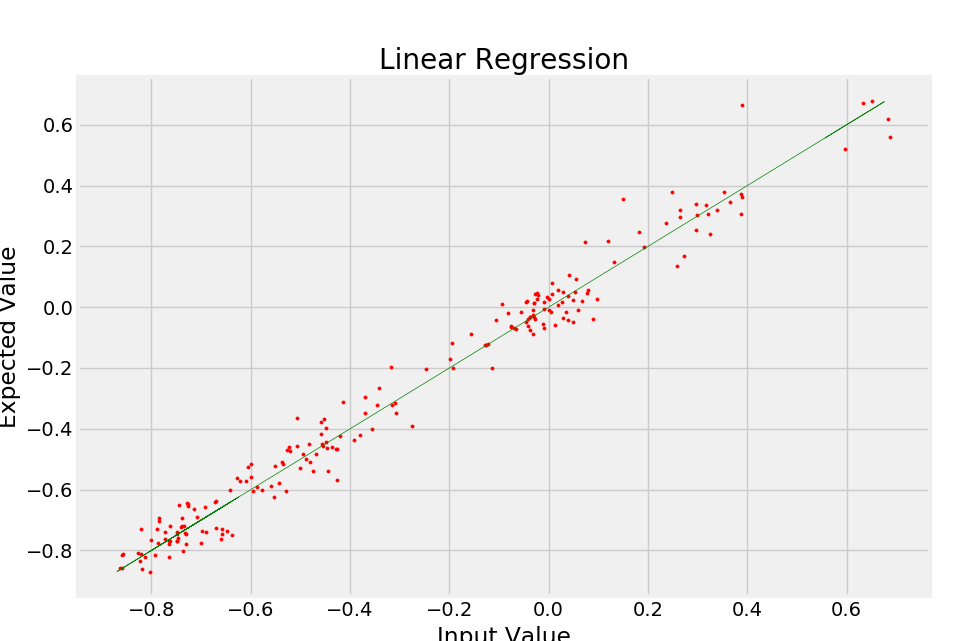

In [15]:
linear_regression(data)

Draw moving average, candlesticks, stochastics oscillator.

<IPython.core.display.Javascript object>


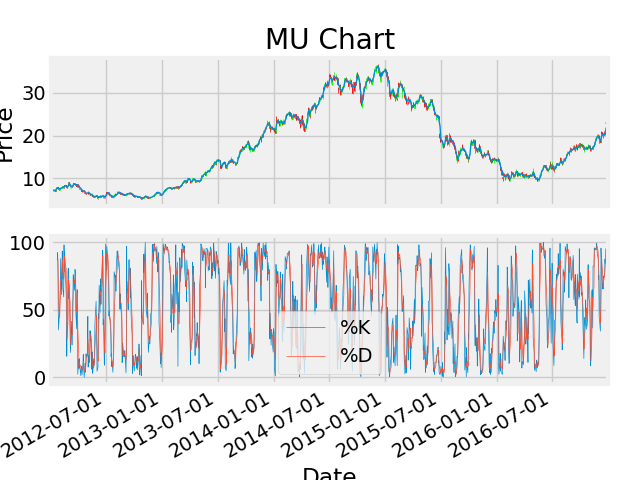

In [16]:
price_oscillator(data)

Draw the on-balance Volume.

<IPython.core.display.Javascript object>


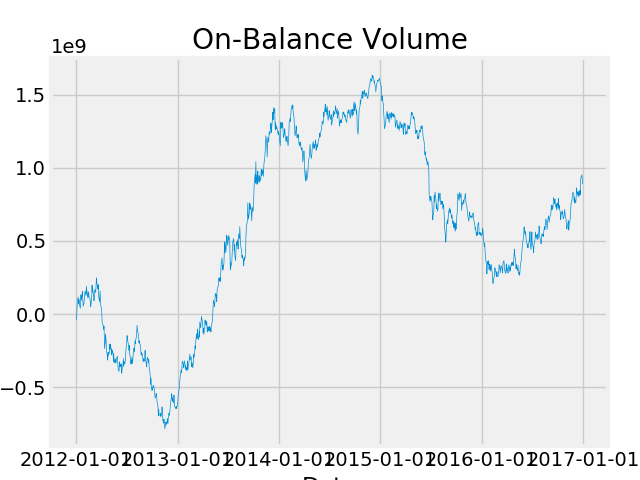

In [17]:
obv(data)

Design making system based on linear regression.